In [1]:
%config Completer.use_jedi=False
import numpy as np
import pandas as pd
import scipy.stats as sps
import math
from scipy.special import gamma
from scipy.optimize import bisect
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.notebook import trange 
import time
import matplotlib.ticker as mtick
# from functions.cython_qrHeston import *
from utils import *
import torch
torch.set_printoptions(precision=10)

import torch.distributions as tdist

### Monte Carlo simulation

####  Quadratic rough Heston model
$$
\begin{aligned}
dS_t&=S_t\sqrt{V_t}dW_t \\
V_t&=a(Z_t-b)^2+c
\end{aligned}
$$
where $W$ is a Brownian motion and $a,\,b,\,c>0$. This model is of rought Heston type, in the sense that weighted past price returns are drivers of the volatility dynamics:
$$Z_t=\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}(\theta_0(s)-Z_s)ds+\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}\eta\sqrt{V_s}dW_s$$
with $\alpha\in(1/2,\,1),\,\lambda>0,\,\eta>0$ and $\theta_0$ a deterministic function.



For simplicity, $\theta_0(t)=\cfrac{Z_0}{\lambda\Gamma(1-\alpha)}t^{-\alpha}$, so we have
$$Z_t=Z_0-\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}Z_sds+\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}\eta\sqrt{V_s}dW_s$$

The parameters to calibrate are $v=(\alpha, \lambda, a,b,c, Z_0)\in\mathbb{R}^6$(Note that we can always take $\eta=1$ up to a rescaling of the other parameters).

To simulate the paths for $S,\,V$, we use the following discretization (set $X_t = \log(S_t)$, by Itô's formula, $dX_t = -\frac{1}{2}V_tdt+\sqrt{V_t}dW_t$):

**Step 0:** Initialize $Z_0,\,X,\,V,\,Z$;

**Step 1:** Set the time step length $\Delta t$, generate the Brownian motion $W$;

**Step 2:** for $n=1, 2,\dots, N(timesteps)$,
\begin{aligned}
X_{t_n} &= X_{t_{n-1}}-\frac{1}{2}V_{t_{n-1}}\Delta t+\sqrt{V_{t_{n-1}}}\,(W_{t_n}-W_{t_{n-1}}\,);\\
Z_{t_n} &= Z_0 - \sum_{i=0}^{n-1}(t_n-t_i)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}Z_{t_i}\Delta t+\sum_{i=0}^{n-1}(t_n-t_i)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}\sqrt{V_{t_i}}(W_{t_{i+1}}-W_{t_i})\\
&=Z_0 - \frac{\lambda}{\Gamma(\alpha)}\sum_{i=0}^{n-1}(t_n-t_i)^{\alpha-1}(Z_{t_i}\Delta t-\sqrt{V_{t_i}}(W_{t_{i+1}}-W_{t_i}));\\
V_{t_n} &= a(Z_{t_n}-b)^2+c.
\end{aligned}
**Step 3:** Output $S_{n} = \exp(X_n),\,n=0,1,\dots,N$.

In [4]:
S0 = 5.24

maturities = np.array([0.06, 0.15, 0.31, 0.56])
strikes = np.array([5.25, 5.50, 5.75, 6.00, 6.25])
strike_dim = len(strikes)
maturities_dim = len(maturities)
# torch.cuda.is_available()

In [13]:
class qrHeston:
    """
    A Monte Carlo class for simulating the stochastic models (ex: Heston, rough Heston...)
            
     
    """
    def __init__(self, params, S0, dt = 0.004, Tmin = 0.25, Tmax=2., r = 0.0):
        
        # Time discretisation parameters, maturitiy <= 2 year
        self.Tmax  = Tmax  
        self.Tmin = Tmin
        self.dt =  dt #Tmax/nbTimeSteps
        
        # Time gird is divided into 3 parts, about 1 day for T<3months(0.25year), 2d for T<=6months, 3d for T>6months
        self.time_grids = [torch.arange(0., Tmin, dt), torch.arange(0., 2*Tmin, 2*dt), torch.arange(0., Tmax, 3*dt)]
        
        # Spot price
        self.S0 = S0
        
        # risk-free interest
        self.r = r
        
        # qrHeston parameters
        self.alpha, self.Lambda, self.a, self.b, self.c, self.Z0 = params
        self.coef = self.Lambda/gamma(self.alpha)
        
    
    
    def qrHeston_single_stockPaths(self, T, nbPaths):
        """
        Monte Carlo Simulation for the quadratic rough Heston model
        Input: 
            T: maturity
            nbPaths: number of paths
        
        Output:
            An array of Stock price paths at maturity T, with each row(axis=0) a simulation path 
            
        """
        ## choose the proper time grid for the maturity T
        if T <= self.Tmin:
            time_grid = self.time_grids[0] 
        elif T <= 2*self.Tmin:
            time_grid = self.time_grids[1]
        else:
            time_grid = self.time_grids[2]
            
        dt = time_grid[1] - time_grid[0]
#         dtsqrt= torch.sqrt(dt)
        
        nbTimeSteps = int(T/dt)
    
        # Generate a Brownian Motion sequence
#         W = torch.randn([nbPaths, nbTimeSteps])*dtsqrt
        W = torch.normal(mean=torch.zeros([nbPaths, nbTimeSteps]), std=torch.sqrt(dt))
        S, Z, V = torch.zeros([3, nbPaths, nbTimeSteps])
#         X[:, 0] = torch.full((nbPaths, ), np.log(self.S0))
        S[:, 0] = torch.full((nbPaths, ), self.S0)

        Z[:, 0] = torch.full((nbPaths, ), self.Z0)
        V[:, 0] = torch.full((nbPaths, ), self.a * (self.Z0 - self.b)**2 + self.c)

        for i in trange(1, nbTimeSteps):
            ti   = torch.pow(time_grid[i] - time_grid[: i], self.alpha - 1)
#             print(ti)
            Zi   = Z[:, : i]
            Vi   = V[:, : i]
            Wi   = W[:, : i] 
            tmp = torch.matmul(dt*Zi - torch.sqrt(Vi)*Wi, ti)
            Z[:, i] = self.Z0 - self.coef*tmp
#             Z[i] = self.Z0 - coef*dt*np.sum(ti*Zi) + coef*np.sum(ti*np.sqrt(Vi)*Wi)
            V[:, i] = self.a * (Z[:, i] - self.b)**2 + self.c
#             X[:, i] = X[:, i-1] -0.5*V[:, i-1]*dt + torch.sqrt(V[:, i-1])*W[:, i-1]
            S[:, i] = S[:, i-1]*(1 + torch.sqrt(V[:, i-1])*W[:, i-1])
         
#         return torch.exp(X)
        return S

    
    def qrHeston_multiple_stockPaths(self, nbPaths, T_max):
        """
        Monte Carlo Simulation for the quadratic rough Heston model
        Input: 
            nbPaths: number of paths
        
        Output:
            A list of 3 arrays of Stock price paths at maturity 3 months, 6 months and 2 years, respectively.
            
        """
        if T_max > 2*self.Tmin:
            Ts = [self.Tmin, 2*self.Tmin, self.Tmax]
        elif T_max > self.Tmin:
            Ts = [self.Tmin, 2*self.Tmin]
        else:
            Ts = [self.Tmin]
            
        multi_paths = [self.qrHeston_single_stockPaths(T, nbPaths) for T in Ts]
        
        return multi_paths
        
            
    def qrHeston_CallPut(self, strikes, maturities, N = 100000, call_put = 1):
        """
        Compute the call/put option price with call_put = 1/-1 for "Call/Put"  for given strikes and maturities
        
        Output:
            A list with each element the call/put prices for the strike(s) and maturity(maturities)
            A list of (Average, standard deviation and maximum) relative errors of the Monte Carlo for each maturity-strike
        """
        callput_prices = torch.zeros(len(strikes)*len(maturities))
#         errors = tf.zeros((3, dim))
        
        multi_paths = self.qrHeston_multiple_stockPaths(N, T_max=maturities[-1])
        i = 0
        for T in maturities:
            if T <= self.Tmin:
                paths = multi_paths[0]
                dt = self.dt
            elif T <= 2*self.Tmin:
                paths = multi_paths[1]
                dt = 2*self.dt
            else:
                paths = multi_paths[2]
                dt = 3*self.dt
                
            stop = int(T/dt)-1 ##+1?
            stockPrice = paths[:, stop]
            
            for K in strikes:
                tmp   = torch.maximum(call_put*(stockPrice - K), torch.tensor([0.0]))
                callput_prices[i] = torch.mean(tmp)*torch.exp(torch.tensor([-self.r * T]))
#                 try:
#                     errors[:, i] = self.compute_relative_errors(tmp)
#                 except:
#                     pass
                i += 1
        return callput_prices               
#         return callput_prices, errors

In [14]:
S0 = 100.
maturities = np.array([0.05, 0.1, 0.2, 0.3, 0.5])
strikes = np.array([90., 95., 97., 99., 100., 101., 103., 105.])

#### Parameters for quadratic rough Heston
params = [0.6863, 1.3481, 0.5816, 0.2573, 0.0039, 0.2392]
alpha, Lambda, a, b, c, Z0 = params
# Z0 = 0.1
# alpha = 0.55
# a = 0.384
# b = 0.095
# c = 0.0025
# Lambda = 1.2

qrheston_params = {'alpha': alpha, 'Lambda': Lambda, 'a': a, 'b': b, 'c': c, 'Z0': Z0}

In [15]:
%%time
MC = qrHeston(params, S0 = S0, r=0.03)
# call_prices, errors= MC.qrHeston_CallPut(strikes, maturities)
call_prices= MC.qrHeston_CallPut(strikes, maturities)

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Wall time: 6.47 s


In [16]:
call_prices, len(call_prices)

(tensor([9.9867658615e+00, 5.0048451424e+00, 3.0478284359e+00, 1.2649281025e+00,
         5.9290611744e-01, 1.9542355835e-01, 9.5123508945e-03, 5.4959277622e-04,
         9.9927597046e+00, 5.0959901810e+00, 3.2402949333e+00, 1.6066387892e+00,
         9.5987308025e-01, 4.8670414090e-01, 7.3644571006e-02, 9.0510519221e-03,
         1.0080286980e+01, 5.3958230019e+00, 3.6795561314e+00, 2.1725347042e+00,
         1.5393650532e+00, 1.0133229494e+00, 3.3243137598e-01, 7.5961835682e-02,
         1.0218633652e+01, 5.7023558617e+00, 4.0719933510e+00, 2.6287343502e+00,
         2.0042660236e+00, 1.4601196051e+00, 6.5143591166e-01, 2.1859997511e-01,
         1.0686314583e+01, 6.4569063187e+00, 4.9367265701e+00, 3.5648581982e+00,
         2.9471533298e+00, 2.3836417198e+00, 1.4373112917e+00, 7.5697636604e-01]),
 40)

In [8]:
call_prices, len(call_prices)

(tensor([9.9905033112e+00, 5.0081267357e+00, 3.0509216785e+00, 1.2696353197e+00,
         5.9705871344e-01, 1.9746580720e-01, 9.7668701783e-03, 5.5103685008e-04,
         9.9921226501e+00, 5.0987787247e+00, 3.2453413010e+00, 1.6110430956e+00,
         9.6456640959e-01, 4.9021092057e-01, 7.4815459549e-02, 9.2849964276e-03,
         1.0095814705e+01, 5.4109210968e+00, 3.6954283714e+00, 2.1857650280e+00,
         1.5510662794e+00, 1.0233961344e+00, 3.3737656474e-01, 7.7242292464e-02,
         1.0207456589e+01, 5.7001247406e+00, 4.0690741539e+00, 2.6256294250e+00,
         2.0006024837e+00, 1.4564546347e+00, 6.5032511950e-01, 2.1930740774e-01,
         1.0690284729e+01, 6.4642167091e+00, 4.9456210136e+00, 3.5757384300e+00,
         2.9590985775e+00, 2.3950357437e+00, 1.4499455690e+00, 7.6606398821e-01]),
 40)

In [37]:
call_prices, len(call_prices)

(tensor([9.9914436340e+00, 5.0077018738e+00, 3.0484476089e+00, 1.2695158720e+00,
         6.0600119829e-01, 2.0858132839e-01, 1.0107267648e-02, 4.8877188237e-04,
         9.9793376923e+00, 5.0832362175e+00, 3.2328341007e+00, 1.6083334684e+00,
         9.6724492311e-01, 4.9722012877e-01, 7.7166698873e-02, 8.5316877812e-03,
         1.0099036217e+01, 5.4124703407e+00, 3.6980755329e+00, 2.1929676533e+00,
         1.5610193014e+00, 1.0340718031e+00, 3.4678870440e-01, 7.9129949212e-02,
         1.0216846466e+01, 5.7085886002e+00, 4.0861043930e+00, 2.6551966667e+00,
         2.0362160206e+00, 1.4960807562e+00, 6.8582642078e-01, 2.3995797336e-01,
         1.0685342789e+01, 6.4796700478e+00, 4.9730925560e+00, 3.6143226624e+00,
         3.0026421547e+00, 2.4441318512e+00, 1.5027027130e+00, 8.1699609756e-01]),
 40)

In [20]:
from quadratic_rHeston import *

In [21]:
%%time 
MC = qrHeston(params, S0=S0)
call_prices= MC.qrHeston_CallPut(strikes, maturities)

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Wall time: 12 s


In [22]:
call_prices

array([1.00001522e+01, 5.00843773e+00, 3.04756223e+00, 1.26794977e+00,
       6.05108890e-01, 2.08184538e-01, 1.04661176e-02, 5.98404042e-04,
       1.00137836e+01, 5.10468898e+00, 3.24931537e+00, 1.61824452e+00,
       9.74663339e-01, 5.02043897e-01, 7.85898513e-02, 9.44920587e-03,
       1.01584533e+01, 5.44869183e+00, 3.72732195e+00, 2.21715113e+00,
       1.58323108e+00, 1.05312431e+00, 3.55754318e-01, 8.21692678e-02,
       1.03064442e+01, 5.75833729e+00, 4.12081331e+00, 2.67584676e+00,
       2.05125934e+00, 1.50651428e+00, 6.92720319e-01, 2.45477094e-01,
       1.08076875e+01, 6.54728042e+00, 5.01870430e+00, 3.64236003e+00,
       3.02462142e+00, 2.46165437e+00, 1.51625466e+00, 8.25621645e-01])

In [ ]:
impliedVols(S0, strikes, maturities,prices = call_prices)

In [ ]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)

plt.figure(1,figsize=(17,4))
ax=plt.subplot(1,3,1)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(errors[0].reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(errors[1].reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(errors[2].reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

5


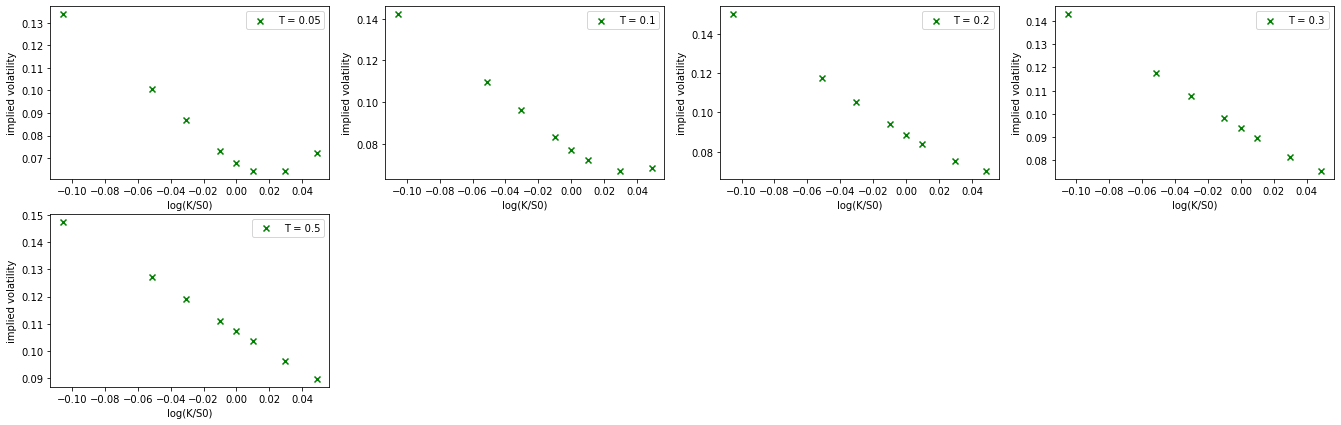

In [23]:
# call_prices
axisX = []
axisY = []
strikes_dim=len(strikes)
maturities_dim=len(maturities)

for i in range(maturities_dim):
    x = []
    y = []
    for j in range(strikes_dim):
        try:
            y.append(impliedVol(S0, strikes[j], maturities[i], call_prices[i*strikes_dim + j]))
            x.append(np.log(strikes[j]/S0))
        except:
            pass
    axisX.append(x)
    axisY.append(y)
    
print(len(axisX)) 
f = plt.figure(1, figsize=(23, 7))
for i in range(len(maturities)):
    plt.subplot(2, 4, i+1)
    plt.scatter(axisX[i], axisY[i], c='g', marker='x', label="T = %s"%maturities[i])
    plt.xlabel("log(K/S0)")
    plt.ylabel("implied volatility")
    plt.legend(loc=1)
plt.show();

In [ ]:
zip?

In [ ]:
# time = np.arange(N)
# f = plt.figure(figsize=(16,4))
# ax1 = plt.subplot(121)
# ax1.plot(time, S, label = "qrHeston")
# ax1.grid()
# ax1.set_xlabel("time")
# ax1.set_ylabel("Prices")
# ax1.legend(loc=1)

# ax2 = plt.subplot(122)
# ax2.plot(time, iv, label = "qrHeston")
# ax2.grid()
# ax2.set_xlabel("time")
# ax2.set_ylabel("implied volatility")
# ax2.legend(loc=1)
# plt.show()


In [ ]:
import multiprocessing

multiprocessing.cpu_count()

In [ ]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)

x = np.log(strikes/S0)
f = plt.figure(1, figsize=(23, 7))
for i in range(len(maturities)):
    plt.subplot(2, 4, i+1)
    y = ivs_[7][i*strikes_dim: (i+1)*strikes_dim]
    plt.scatter(x, y, c='g', marker='x', label="T = %s"%maturities[i])
    plt.xlabel("log(K/S0)")
    plt.ylabel("implied volatility")
    plt.legend(loc=1)
plt.show();

In [ ]:
from functions.cython_quadratic_rHeston import *

In [24]:
np.linspace(0,3,11)

array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ])

In [23]:
from scipy.interpolate import UnivariateSpline
x = np.linspace(0, 10, 70)
y = np.sin(x)
spl = UnivariateSpline(x, y, k=4, s=0)
spl.derivative().roots()

array([1.57079637, 4.71238899, 7.85398159])

In [19]:
dir(spl)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data',
 '_eval_args',
 '_from_tck',
 '_reset_class',
 '_reset_nest',
 '_set_class',
 '_spline_class',
 'antiderivative',
 'derivative',
 'derivatives',
 'ext',
 'get_coeffs',
 'get_knots',
 'get_residual',
 'integral',
 'roots',
 'set_smoothing_factor',
 'validate_input']

array([1.57079637, 4.71238899, 7.85398159])